# We'll work with some classification systems with the mnist dataset

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"] #X are images of numbers and y are the suposed label of the image 
#that represents the digit

In [3]:
X.shape #70000 images with 784 features each (28x28 pixels)

(70000, 784)

In [4]:
y.shape

(70000,)

# We can take a peek at one digit from the dataset

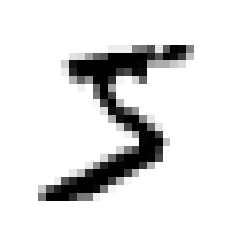

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [6]:
y[0] #looks like a 5 and indeed it is

'5'

In [7]:
import numpy as np
y = y.astype(np.uint8) #We transform label into string so we cast y to integer

# This set is already split into a training and test set. (The training set is already shuffled)

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# We simplify the problem first trying to identify only one digit (the number 5 for now). For that we create two clases

In [9]:
y_train_5 = (y_train == 5) #True for all 5s, False for all other digits
y_test_5 = (y_test == 5) 

# Now we pick a classifier and train it, We begin with an stochastic gradient descent (sgd) classifier.

In [10]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

SDGClassifier relies on randomness during training (hence the name stochastic). For reproducible results, we should set random_state parameter.

# And then we can use it to detect images of the number 5

In [11]:
sgd_clf.predict([some_digit]) 

array([ True])

The clasifier guesses that this image represents a 5(True). This appear to have to be a right guess in this particular case but we need to evaluate model's performance.

We can implement cross validation by ourselves if we need some more control over the cross validation process
The following code does roughly the same thing as scikit-learn's cross_val_score() function, and it prints
the same result

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):#skfolds.split gives indices to split data into
#training and test
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred)) #prints 0.9502, 0.96565 and 0.96495

/home/axl/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


# Now we can do the same with the cross_val_score() function to evaluate the model using k-fold validation with three folds

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Above 93% it's a very high accuracy but first let's check out a dumb classifier that classifies every ingle image in the "not 5" class

In [14]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1),dtype=bool) #creates an array of len(X) times 1 and with dtype = bool we make it
                                               #all false

In [15]:
#So let's test the accuracy of our model
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

We also get 90% of accuracy. The issue is that only about 10% of images are 5s, so if you always get an image is not a 5, you will be right about 90% of the time. That's the reason why accuracy is generaly not preferred as a performance measure for classifiers, especially when you're dealing with skewed datasets(i.e some classes are much more frequent than others)

# It's better to look at a confusion matrix for classifiers, counting the number of times instanes of class A are classified as B

# For this is necessary to first have a set of predictions so that they can be compared with the actual targets.

# To not touch the test set we use the cross_val_predict() function

In [16]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5,cv=3) #performs k fold validationn on 3 folds 
#and returns the predictions made on each test fold.

In [17]:
#So now we can get our confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

The matrix is described like this $$\begin{pmatrix} \text{correctly classified as non 5} && \text{wrongly classified as 5} \\ \text{wrongly classified as non 5} && \text{correclty classified as 5} \end{pmatrix}$$
So we have $$\begin{pmatrix} \text{True negatives} && \text{false positives} \\ \text{false negatives} && \text{true positives} \end{pmatrix}$$

To get a more concise metric we calculate the
$$precision = \frac{\text{true positives}}{\text{true positives} + \text{false positives}}$$

And to avoid ignore all but one positive instance we use it along with another metric 
$$recall= \frac{ \text{true positives} }{ \text{true positives} + \text{false negatives} }$$

So we can calculate this metrics with scikit-learn

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096/(4096+1522)

0.8370879772350012

In [19]:
recall_score(y_train_5,y_train_pred) # == 4096/(4096 + 1325)

0.6511713705958311

# So we have an 83% of accuracy but our model only detects 65% of the 5s

We can combine precision and recall into a single metric called $F_{1}$ score, This is called harmonic mean of precision and recall. This gives much more weight to low values contrary to regular mean that treats all values equally. As a result we only could get a high $F_{1}$ if both recall and precision are high.
$$F_{1} = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = \frac{\text{True Positives}}{\text{True Positives} + \frac{\text{False Negatives} + \text{False Positives}}{2}} $$.

## So to calculate $F_{1}$ score we only call the f1_score() function:

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

$F_{1}$ favors classifiers with similar precision and recall but this is not always the case. Sometimes(often) there's a tradeoff between precision and recall. Usually incresing precision reduces recall and vice versa.
Depending on where we set the threshold of classification we can change the values of precision and recall.

We can't modify the threshold in scikit-learn directly but we can access to the decision scores that it uses to make predictions by instead of calling the predict() method we call it's decision_function() method which returns a score for each instance and then use any threshold to make predictions based on those scores.

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([ True])

We can raise the threshold

In [23]:
threshold = 8000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

So raising the threshold decreases recall by raising the threshold of the score obtained by the classificator.
To find a proper threshold we could use cross_val_predict() function to get the scores of all instances in the training set specifiying we want to return the decision scores instead of predictions

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")

With these scores we can use the precision_recall_curve() function to compute precision and recall for all possible thresholds

In [25]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

Finally with matplotlib we can plot precision and recall as functions of the threshold value

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],"b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlim(-50000,50000)
    plt.ylim(0,1)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid()

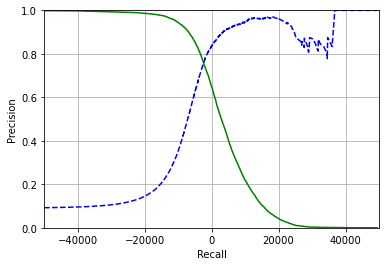

In [27]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Or we could also plot directly precision agains recall

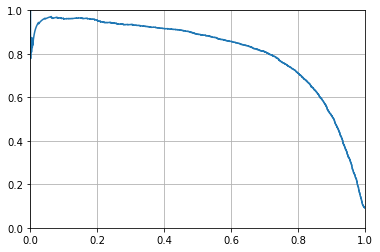

In [28]:
plt.plot(recalls,precisions)
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()

We could search the lowest threshold that gives 90% precision

In [29]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816

To make predictions instead of predict() we could use

In [30]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

And so we get

In [31]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [32]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

A low recall would be bad even if we get a very high precision

Another common tool with binary classifiers is the receiver operating characteristic(ROC). Here we plot the true positive rate(recall) agains  the false positive rate(FPR). FPR is the ratio of negative instances incorrectly classified as positive. It's equal to $1 - \text{true negative rate}(TNR)$ which is the ratio of negative instances that are correctly classified as negative. The TRN is also called specificity. And so the ROC curve plots sensitivity(recall) vs 1-speccificity

In [33]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--') #Dashed diagonal
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.ylabel("True positive rate(Recall)")
    plt.xlabel("False positive rate")

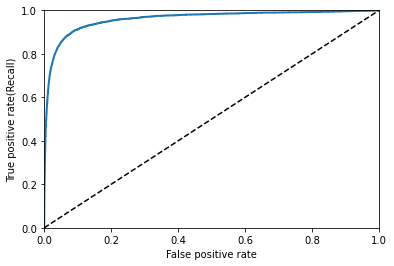

In [35]:
plot_roc_curve(fpr,tpr)
plt.show()

Comparing the area under the curve (auc) we can compare classifiers (perfect ROC AUC equal 1, random ROC AUC 0.5). To compute the ROC AUC we can use

In [36]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

We should prefer the PR curve whenever the positive class is rare or when you care more about the false positives
than the false negatives. Otherwise, use the ROC curve.

# Now training a RFC and compare its ROC curve and ROC AUC score to those of the SDGClassifier

In [37]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5,cv=3, method="predict_proba")

In [38]:
y_scores_forest = y_probas_forest[:,1] #score=poba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

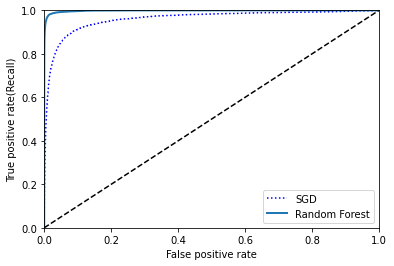

In [39]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

# Random Forest has a higher true positive rate with a lower false positive rate than the SGD

In [40]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

In [41]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5,cv=3) 

In [42]:
precision_score(y_train_5,y_train_pred_forest)

0.9905083315756169

In [43]:
recall_score(y_train_5,y_train_pred_forest)

0.8662608374838591

# Now we'll dive into multiclass classification

SGD, Random Forests and naive Bayes are capable of multiclass classification natively

Logistic Regression and SVM are strictly binary and require strategies to perform multiclass classification

An strategy for example to classify into n classes is to train n binary classifiers. This is called one-versus-the-rest(OvR) strategy(also called one versus all). We could also train a binary classifier for every pair of classes. This is one-versus-one (OvO) strategy. For n classes we'll need n*(n-1)/2 classifiers. For most classifiers OvR is preferred and OvO when the classifier scales poorly with the training set.

Scikit-Learn detects multiclass classification in binary classifiers and it automatically runs OvR or OvO depending on the algorithm

# We'll try SVM with multiclass classification

In [44]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,y_train) #y_train, not y_train_5
svm_clf.predict([some_digit]) #trains the SVC on the trainint set using all the original classes (0-9) and makes 
#the prediction. 

array([5], dtype=uint8)

In reality Scikit-Learn used OvO and trained 45 binary classifiers, got their decision scores for the image, and
selected the class that won the most duels.

In [45]:
some_digit_scores = svm_clf.decision_function([some_digit]) #some_digit is number 5
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [46]:
np.argmax(some_digit_scores) #highest score is indeed corresponding to class 5

5

In [47]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [48]:
svm_clf.classes_[5]

5

In [49]:
#We can force Scikit-Learn to use OvO or OvR. This code creates a multiclass classifier using the OvR strategy
#based on a SVC
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [50]:
len(ovr_clf.estimators_)

10

In [51]:
#We can also train an SGDClassifier (or a RandomForestClassifier) easily
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit]) #SGD classifiers can directly classify instances into multiple classes
#so OvR or OvO are not needed.

array([3], dtype=uint8)

In [52]:
#So decision_function() method returns one value per class and we can look at the score that the SGD classifier
#assigned to each class
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [53]:
#Almost all scores are largely negative while class 5 has a largely positive score.
#So we can evaluate this classifier with cross_validation_score()
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [54]:
#And we get 84% on all test folds and if we scale the inputs accuracy increases above 89%
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

If we already found a promising model and want to find ways to improve it we could analyze the types of errors it makes. Let's check first at the cross_val_predict() function and then call the confusion_matrix()

In [55]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

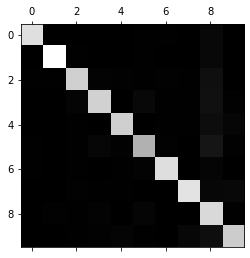

In [56]:
#We can see an image representation of the confusion matrix using the matshow() function
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show() 

Since most images are on the main diagonal means they are classified correctly. 5s are slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not performas well on 5s as on other digits.

To plot the errors we divide each value in the confusion matrix by the number of images in the correspoding class to compare the error rates instead of absolute numbers of errors

In [57]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx/row_sums

# We fill the diagonal with zeros to keep only the errors, and plot the result to visualize the matrix of errors

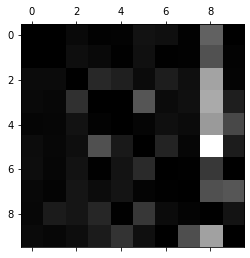

In [58]:
np.fill_diagonal(norm_conf_mx, 0) 
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Rows represent the actual classes while columns represent predicted classes. The bright 8 column means many images got misclassified as 8s but the row for 8s looks good meanin that actual 8s were generally properly classified as 8s.

In [59]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] #Here we're gonna plot the 3s and 5s train and predictions
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [60]:
def plot_digits(instances, images_per_row=10, **options): #Function to plot the digits
    # instances has shape [?, 784]. Each row represents a 28x28 image.
    size = 28
    # if this function is called with just (say) 3 images, but images_per_row is larger, then we should
    # fix images_per_row to make it equal to the number of images:
    images_per_row = min(len(instances), images_per_row)

    # We now reshape every image to make it 28x28 instead of a one-dimensional vector of size 784:
    images = [instance.reshape(size,size) for instance in instances]

    # Given the number of images and the number of images per row, let's compute the number of rows.
    # The following is equivalent to `ceil(len(instances) / images_per_row)`, but it doesn't require
    # `import ceil from math`:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # For each row of images, we'll construct a single wide image made out of all the images in the row:
    row_images = []

    # If the number of images is not a multiple of the number of images per row, then we must pad the final
    # row with some number of empty images. Let's compute how many we need and add them to the list of
    # images:
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))

    # now let's loop over the number of rows:
    for row in range(n_rows):
        # Let's grab all the images from the current row:
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        # Now let's concatenate these images horizontally into a single wide image using
        # `np.concatenate()`, and let's add this wide image to the list of row images:
        row_images.append(np.concatenate(rimages, axis=1))

    # Now that we have one wide image per row, let's concatenate all of them
    # vertically into a single big image
    image = np.concatenate(row_images, axis=0)
    # And finally we can just `imshow()` this big image, forwarding any options we were given:
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    # And drop the horizontal and vertical axes (and their labels):
    plt.axis("off")

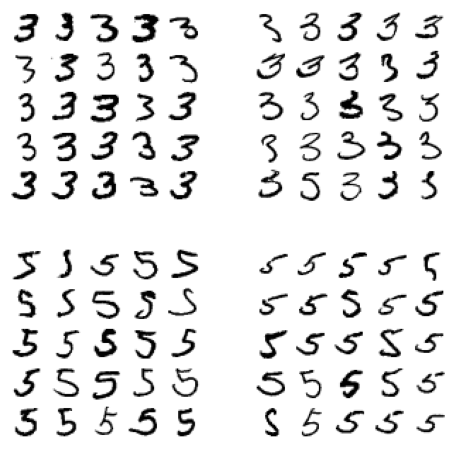

In [61]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row = 5)
plt.show()
#The two 5 × 5 blocks on the left show digits classified as 3s, and the two 5 × 5 blocks on the right 
#show images classified as 5s.

The reason is that we used a simple SGDClassifier ,which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s differ only by a few pixels, this model will easily confuse them. The main difference between 3s and 5s is the position of the small line that joins the top line to the bottom arc. If you draw a 3 with the junction slightly shifted to the left, the classifier might classify it as a 5, and vice versa. In other words, this classifier is quite sensitive to image shifting and rotation. So one way to reduce the 3/5 confusion would be to preprocess the images to ensure that they are well centered and not too
rotated.

# Multilabel classification

Identifies multiple classes in a test object.

In [62]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

This code creates a y_multilabel array containing two target labels for each digit image: the first indicates whether or not the digit is large(7, 8 or 9) and the second identifies whether or not it is odd. Next creates a KNeighborsClassifier instance and train it using multiple targets array.

In [63]:
knn_clf.predict([some_digit]) #Now we make a prediction for digit 5 and notice that it outputs two labels

array([[False,  True]])

And it gets it right because digit 5 is indeed not large(False) and odd(True). To evaluate the classifier we measure the $F_{1}$ score for each individual label and then compute the average score.

In [64]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [65]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# Multioutput Classification

This is just multilable classification where each label can be multiclass (can have more than two possible values)

To ilustrate this, let's build a system that removes noise from images. It will take as input noisy digit image, and it will(hopefully) output a clean digit image. The classifier output will be multilabel(one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255)

In [67]:
#We'll take the MNIST images and add noie to their pixels to create training and test sets
noise = np.random.randint(0, 100, (len(X_train), 784) )
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784) )
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [71]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

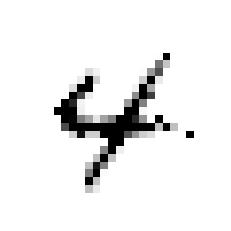

In [79]:
#Now let's train the classifier and make it clean the image
some_index=5500
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

Which looks close enough to the target

# Excercises

## 1

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train)
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)